## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Get data

In [2]:
df= pd.read_excel("E:\\Projects\\python\\Online Retail.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

In [12]:
# Remove rows with negative Quantity and Price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [14]:
df['CustomerID'] = df['CustomerID'].astype(int)

# Verify the data type conversion
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object


## Computing of  Recency, Frequency, and Monetary Values

In [15]:
snapshot_date = max(df['InvoiceDate']) + pd.DateOffset(days=1)

df['Total'] = df['Quantity'] * df['UnitPrice']

In [16]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total': 'sum'
})

In [17]:
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total': 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


## Maping of  RFM Values onto a 1-5 Scale

In [18]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [19]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() - 3, 300, 600, 2000, 5000, rfm['MonetaryValue'].max()]

In [20]:
# Calculate Recency score based on custom bins
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

In [21]:


# Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))
     


            R_Score  F_Score  M_Score
CustomerID                           
12346             1        1        5
12347             5        3        4
12348             3        3        3
12349             5        1        3
12350             1        1        2
12352             4        3        4
12353             2        1        1
12354             2        1        3
12355             2        1        2
12356             4        2        4


## K-Means Clustering

In [23]:
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]

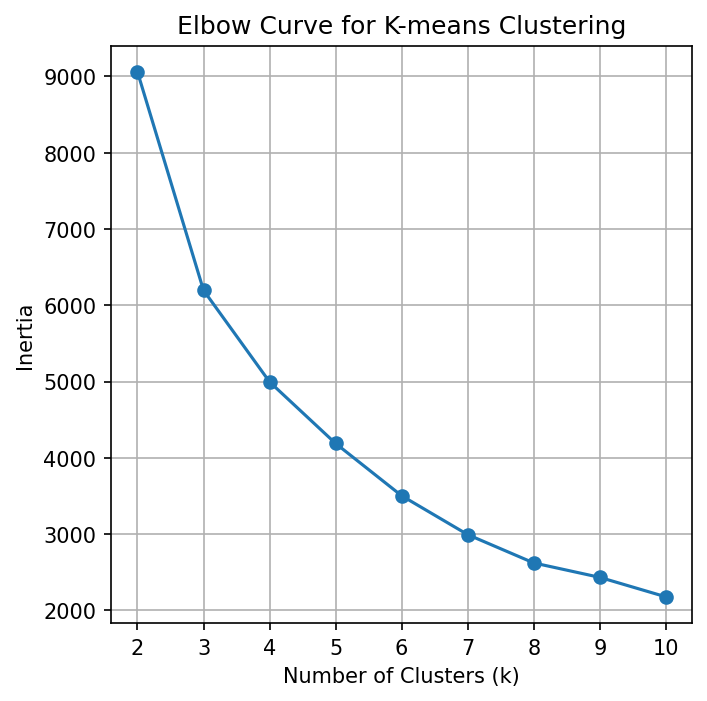

In [26]:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5,5),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

In [27]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

## Interpret the Clusters to Identify Customer Segments

In [28]:
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [29]:
print(cluster_summary)

   Cluster   R_Score   F_Score   M_Score
0        0  1.442263  1.061201  1.505774
1        1  3.013043  1.619130  2.820870
2        2  4.550798  3.169086  3.774311
3        3  4.092161  1.103814  1.505297


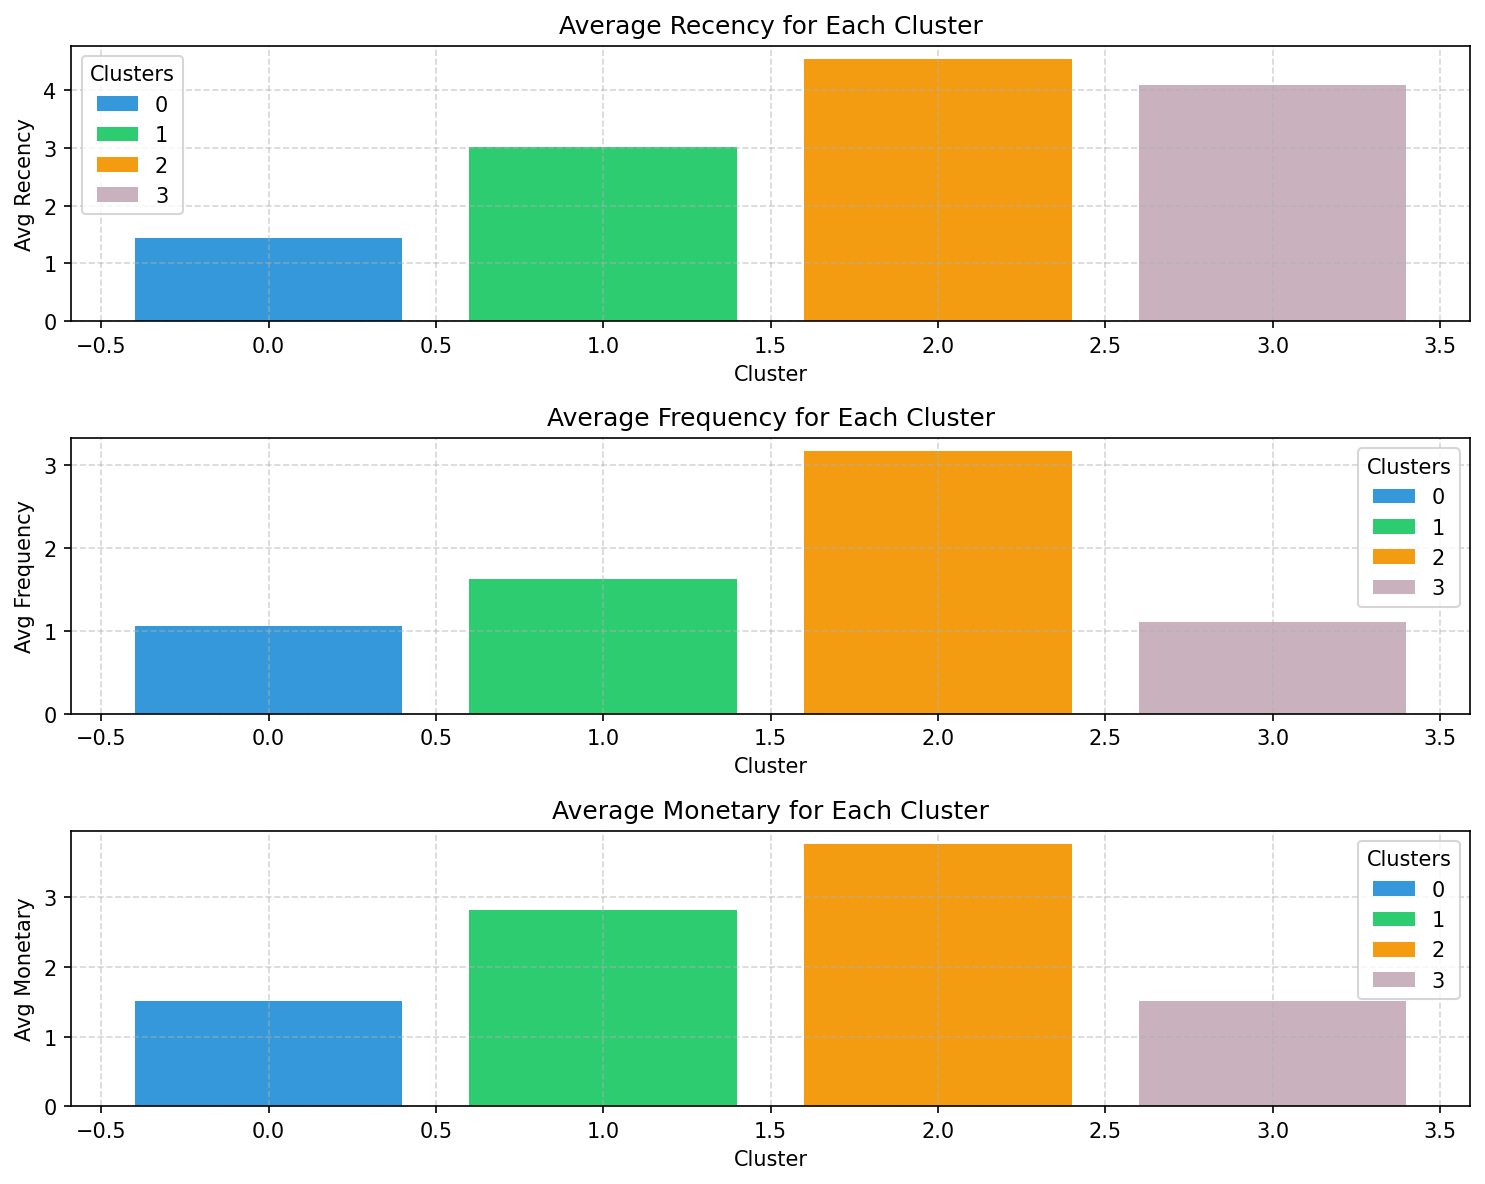

In [30]:
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

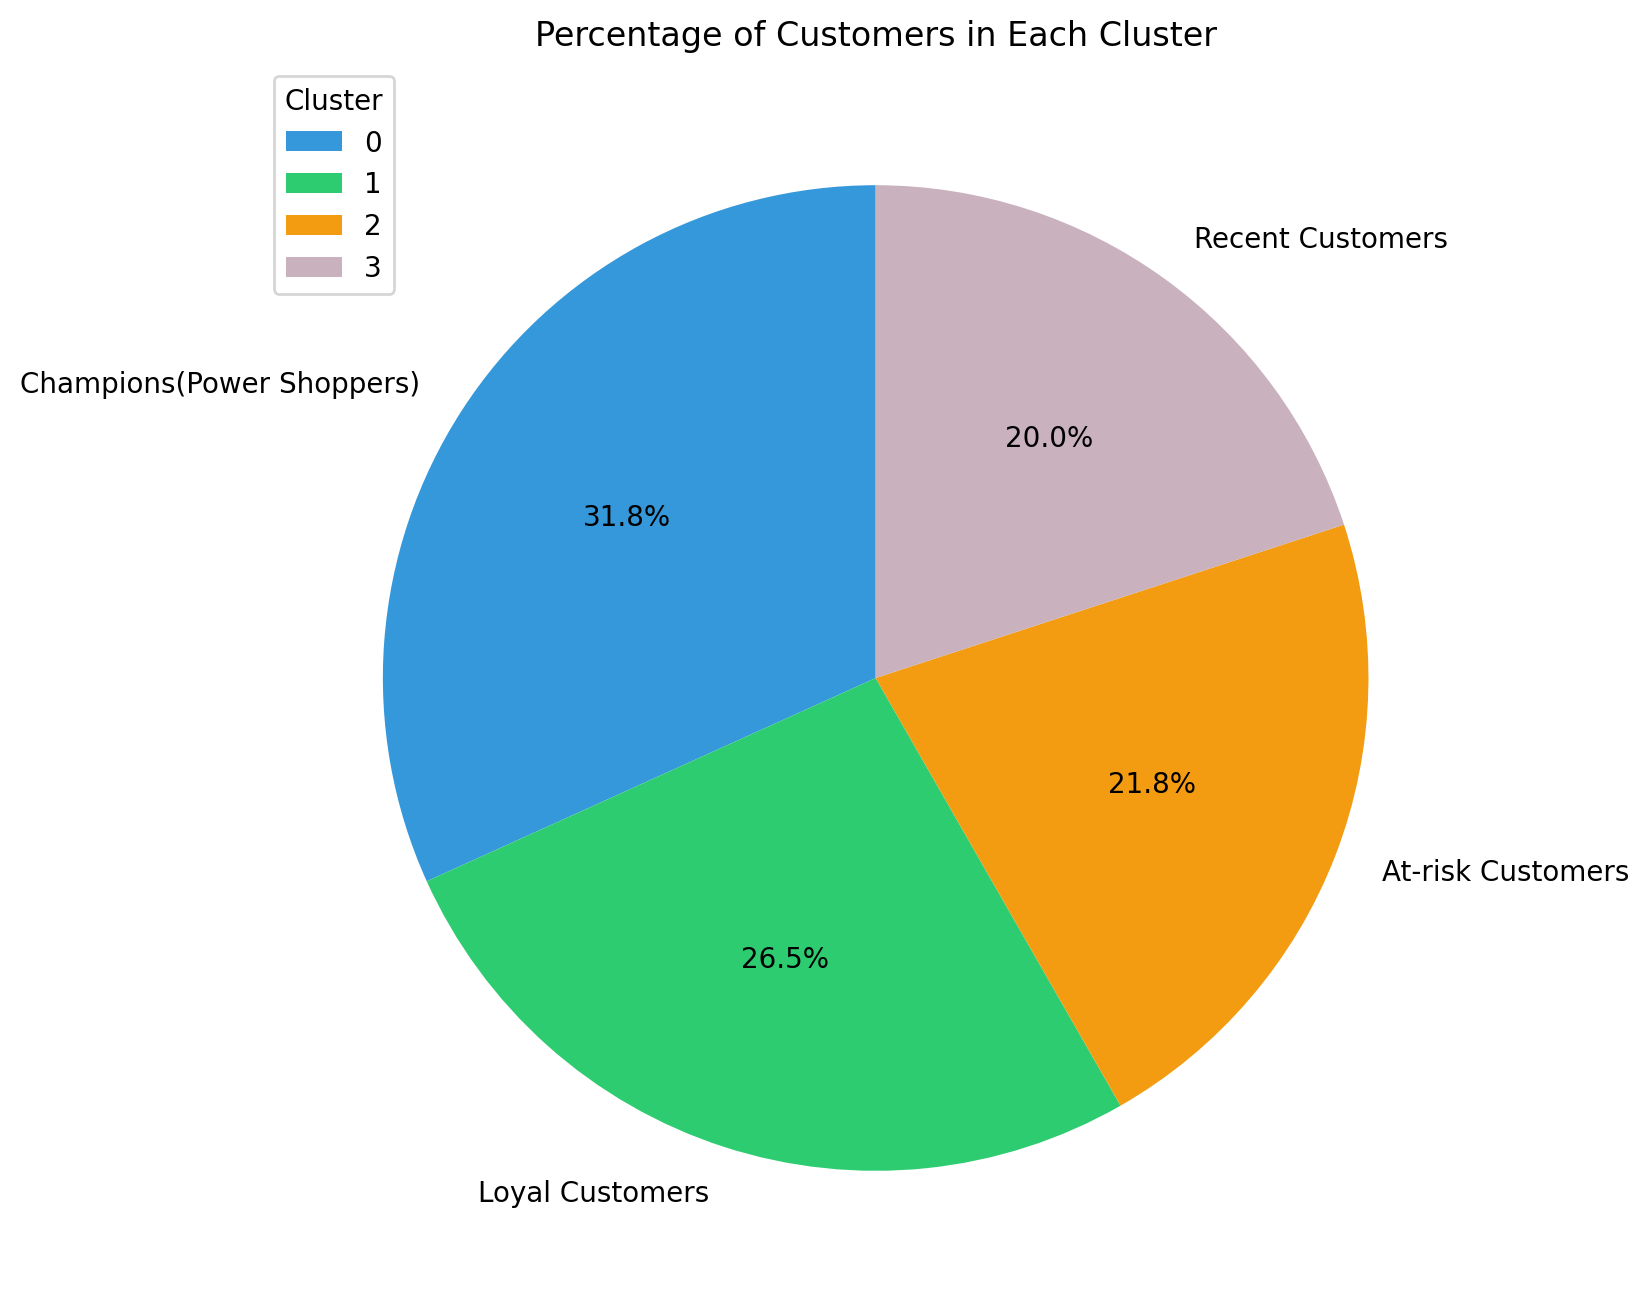

In [31]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Champions(Power Shoppers)','Loyal Customers','At-risk Customers','Recent Customers']

# Create a pie chart
plt.figure(figsize=(8, 8),dpi=200)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='upper left')

plt.show()

In [3]:
df1=pd.read_csv("E:\Projects\python\Market_Basket_Optimisation.csv")

In [4]:
df1.head()

,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,low fat yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from apyori import apriori
import numpy as np

In [46]:
df1.describe(include=object)

,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach
count,7500,5746,4388,3344,2528,1863,1368,980,653,394,255,153,86,46,24,7,3,3,2
unique,115,117,115,114,110,106,102,98,88,80,66,50,42,28,18,7,2,2,2
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,chocolate,frozen smoothie,protein bar,mayonnaise
freq,577,484,375,201,153,107,96,67,57,31,21,14,8,4,3,1,2,2,1


In [59]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   shrimp             7500 non-null   object 
 1   almonds            5746 non-null   object 
 2   avocado            4388 non-null   object 
 3   vegetables mix     3344 non-null   object 
 4   green grapes       2528 non-null   object 
 5   whole weat flour   1863 non-null   object 
 6   yams               1368 non-null   object 
 7   cottage cheese     980 non-null    object 
 8   energy drink       653 non-null    object 
 9   tomato juice       394 non-null    object 
 10  low fat yogurt     255 non-null    object 
 11  green tea          153 non-null    object 
 12  honey              86 non-null     object 
 13  salad              46 non-null     object 
 14  mineral water      24 non-null     object 
 15  salmon             7 non-null      object 
 16  antioxydant juice  3 non

In [6]:
#converting dataframe into list of lists
dataframe_list=[]

# values of range is according to the number of rows and columns
for i in range(1,7500):
    dataframe_list.append([str(df1.values[i,j]) for j in range(0,20)])

## applying apriori algorithm

In [8]:

association_rules = apriori(dataframe_list, min_support=0.0045, min_confidence=0.2,
                            min_lift=3, min_length=2) 
association_results = list(association_rules)

In [62]:
association_results[0]

RelationRecord(items=frozenset({'chicken', 'light cream'}), support=0.004533937858381117, ordered_statistics=[OrderedStatistic(items_base=frozenset({'light cream'}), items_add=frozenset({'chicken'}), confidence=0.29059829059829057, lift=4.842659069325735)])

## 
Inferences from the above

    Support: 0.0045.
    The support is calculated = (chicken + light cream)/(total transactions)

    Confidence: 0.2905
    Confidence = (chicken + light cream)/(light cream)
    The confidence level for the rule is 0.2905, which shows that out of all the transactions that contain light cream, 29.05% percent contain chicken too.

    Lift: 4.84
    Lift = ((chicken + light cream)/light cream)/((chicken)/total)
    The lift of 4.8433 tells us that chicken is 4.8433 times more likely to be bought by the customers who buy light cream compared to the default likelihood sale of chicken.

In [63]:
Rule = []
Support = []
Confidence = []
Lift = []
for item in association_results:
    pair = item[0]
    items = [x for x in pair]
    Rule.append(items)
    Support.append(str(item[1]))
    Confidence.append(str(item[2][0][2]))
    Lift.append(str(item[2][0][3]))

In [64]:
dict = {'Rule': Rule, 'Support': Support, 'Confidence': Confidence, "Lift": Lift} 
d = pd.DataFrame(dict)
d

,Rule,Support,Confidence,Lift
0,"[chicken, light cream]",0.004533937858381117,0.29059829059829057,4.842659069325735
1,"[mushroom cream sauce, escalope]",0.005734097879717296,0.30069930069930073,3.7898219427631195
2,"[pasta, escalope]",0.005867448993199093,0.37288135593220345,4.6995584674547795
3,"[ground beef, herb & pepper]",0.01600213361781571,0.3234501347708895,3.291116093143691
4,"[tomato sauce, ground beef]",0.005334044539271903,0.3773584905660377,3.8396354420009726
5,"[whole wheat pasta, olive oil]",0.008001066808907855,0.2714932126696833,4.129670591906603
6,"[pasta, shrimp]",0.0050673423123083075,0.3220338983050848,4.513891968952954
7,"[chicken, light cream, nan]",0.004533937858381117,0.29059829059829057,4.842659069325735
8,"[frozen vegetables, chocolate, shrimp]",0.005334044539271903,0.2325581395348837,3.2597261464898932
9,"[cooking oil, spaghetti, ground beef]",0.004800640085344712,0.5714285714285714,3.2811201050098444


In [70]:
d.sort_values(['Lift'],ascending=False).head(10)

,Rule,Support,Confidence,Lift
0,"[chicken, light cream]",0.004533937858381117,0.29059829059829057,4.842659069325735
7,"[chicken, light cream, nan]",0.004533937858381117,0.29059829059829057,4.842659069325735
11,"[pasta, nan, escalope]",0.005867448993199093,0.37288135593220345,4.6995584674547795
2,"[pasta, escalope]",0.005867448993199093,0.37288135593220345,4.6995584674547795
28,"[pasta, nan, shrimp]",0.0050673423123083075,0.3220338983050848,4.513891968952954
6,"[pasta, shrimp]",0.0050673423123083075,0.3220338983050848,4.513891968952954
27,"[whole wheat pasta, nan, olive oil]",0.008001066808907855,0.2714932126696833,4.129670591906603
5,"[whole wheat pasta, olive oil]",0.008001066808907855,0.2714932126696833,4.129670591906603
21,"[spaghetti, ground beef, herb & pepper]",0.006400853447126284,0.39344262295081966,4.00329203461085
41,"[nan, spaghetti, ground beef, herb & pepper]",0.006400853447126284,0.39344262295081966,4.00329203461085


In [71]:
d.sort_values(['Lift'],ascending=True).head(10)

,Rule,Support,Confidence,Lift
24,"[spaghetti, ground beef, shrimp]",0.00600080010668089,0.5232558139534883,3.004514049645642
43,"[nan, spaghetti, ground beef, shrimp]",0.00600080010668089,0.5232558139534883,3.004514049645642
16,"[frozen vegetables, spaghetti, shrimp]",0.00600080010668089,0.21531100478468898,3.0179761212717433
37,"[frozen vegetables, nan, spaghetti, shrimp]",0.00600080010668089,0.21531100478468898,3.0179761212717433
47,"[nan, mineral water, milk, frozen vegetables, ...",0.004533937858381117,0.288135593220339,3.0219983406424085
33,"[frozen vegetables, mineral water, spaghetti, ...",0.004533937858381117,0.288135593220339,3.0219983406424085
29,"[pancakes, olive oil, spaghetti]",0.0050673423123083075,0.20105820105820107,3.058286916299087
46,"[pancakes, nan, olive oil, spaghetti]",0.0050673423123083075,0.20105820105820107,3.058286916299087
25,"[olive oil, spaghetti, milk]",0.007200960128017069,0.2030075187969925,3.087937897482042
44,"[nan, olive oil, spaghetti, milk]",0.007200960128017069,0.2030075187969925,3.087937897482042


In [9]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(association_results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence','lifts'])

In [16]:
resultsinDataFrame.head(5)

,Left Hand Side,Right Hand Side,Support,Confidence,lifts
0,light cream,chicken,0.004534,0.290598,4.842659
1,mushroom cream sauce,escalope,0.005734,0.300699,3.789822
2,pasta,escalope,0.005867,0.372881,4.699558
3,herb & pepper,ground beef,0.016002,0.323450,3.291116
4,tomato sauce,ground beef,0.005334,0.377358,3.839635


In [15]:
resultsinDataFrame.sort_values(['lifts'],ascending=False).head(5)

,Left Hand Side,Right Hand Side,Support,Confidence,lifts
0,light cream,chicken,0.004534,0.290598,4.842659
7,light cream,chicken,0.004534,0.290598,4.842659
11,pasta,escalope,0.005867,0.372881,4.699558
2,pasta,escalope,0.005867,0.372881,4.699558
28,pasta,shrimp,0.005067,0.322034,4.513892
